In [1]:
import sys
sys.path.insert(0,'../../FromPublic/detr')
sys.path

['../../FromPublic/detr',
 '/home/nofelvsap/PhD-Ahmad Obeid/ColorectalCancer/NucDETR/PythonScripts',
 '/home/nofelvsap/anaconda3/envs/nucdetr/lib/python310.zip',
 '/home/nofelvsap/anaconda3/envs/nucdetr/lib/python3.10',
 '/home/nofelvsap/anaconda3/envs/nucdetr/lib/python3.10/lib-dynload',
 '',
 '/home/nofelvsap/anaconda3/envs/nucdetr/lib/python3.10/site-packages',
 '/home/nofelvsap/anaconda3/envs/nucdetr/lib/python3.10/site-packages/PyQt5_sip-12.11.0-py3.10-linux-x86_64.egg',
 '/home/nofelvsap/anaconda3/envs/nucdetr/lib/python3.10/site-packages/PyYAML-6.0-py3.10-linux-x86_64.egg',
 '/home/nofelvsap/anaconda3/envs/nucdetr/lib/python3.10/site-packages/IPython/extensions',
 '/home/nofelvsap/.ipython']

In [2]:
from models import backbone
from models.backbone import Backbone
from util.misc import NestedTensor, interpolate, nested_tensor_from_tensor_list
from models import build_model
from datasets import build_dataset
import util.misc as utils
from ipywidgets import FloatProgress

In [3]:
import pdb
from PIL import Image, ImageDraw
import requests
import io
import math
import matplotlib.pyplot as plt
# %config InlineBackend.figure_format = 'retina'

import torch
import torchvision
from torch import nn, optim
from torchvision.models import resnet50, resnet101, resnet18, resnet34
import torchvision.transforms as T
from torchvision import datasets
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor

import numpy
# torch.set_grad_enabled(False);

from torchvision import models

import scipy.io as sio
import os

import cv2

from PIL import Image
import argparse
import time

## Cell ***

In [4]:
def get_pretrained_detr():
  model_original = torch.hub.load('facebookresearch/detr', 'detr_resnet101', pretrained=True)
  model_original.eval();
  model = torch.hub.load('facebookresearch/detr', 'detr_resnet101', pretrained=False, num_classes=2)
  model.eval();

  # change the name of class_embedd to be able to import the weights with different size of last layer
  dic = model_original.state_dict()
  dic['class_embed.new_weight'] = dic['class_embed.weight']
  dic['class_embed.new_bias'] = dic['class_embed.bias']
  del dic['class_embed.weight'], dic['class_embed.bias']
  model.load_state_dict(dic, strict=False)
  return model
model = get_pretrained_detr()



Using cache found in /home/nofelvsap/.cache/torch/hub/facebookresearch_detr_main
/home/nofelvsap/anaconda3/envs/nucdetr/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/nofelvsap/anaconda3/envs/nucdetr/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Using cache found in /home/nofelvsap/.cache/torch/hub/facebookresearch_detr_main


## Backbone: Getting the data

In [5]:
# data_dir_tr = '/content/drive/My Drive/Colab/CRC/datasets/consep/tr'
# data_dir_ts = '/content/drive/My Drive/Colab/CRC/datasets/consep/ts'
data_dir_tr = '../../Datasets/AllTogether/train'
data_dir_ts = '../../Datasets/AllTogether/val'
def load_split_train_test(datadir_tr,datadir_ts,batch_size):
    train_transforms = T.Compose([T.ToTensor(),
                                  T.Resize(300)])
    test_transforms = T.Compose([T.ToTensor(),
                                 T.Resize(300)])
    train_data = datasets.ImageFolder(datadir_tr,       
                    transform=train_transforms)
    test_data = datasets.ImageFolder(datadir_ts,
                    transform=test_transforms)
    # num_train = len(train_data)
    # indices = list(range(num_train))
    # split = int(numpy.floor(valid_size * num_train))
    # numpy.random.shuffle(indices)
    # from torch.utils.data.sampler import SubsetRandomSampler
    # train_idx, test_idx = indices[split:], indices[:split]
    # train_sampler = SubsetRandomSampler(train_idx)
    # test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,shuffle=True)
    testloader = torch.utils.data.DataLoader(test_data,batch_size=batch_size)
    return trainloader, testloader
batch_size = 32
trainloader, testloader = load_split_train_test(data_dir_tr,data_dir_ts,batch_size)
print(trainloader.dataset.classes)

['Negative', 'Positive']


## Backbone: making model

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() 
                                  else "cpu")
torchMdl = resnet101(pretrained=True,progress=True)
torchMdl.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 2))
                                  #nn.Sigmoid() , nn.LogSoftmax(dim=1) nn.LogSoftmax(dim=1)
                                 
# for freezing if needed
# for n,p in torchMdl.named_parameters():
#   if "fc" in n or "layer4" in n:
#     p.requires_grad = True
#   else:
#     p.requires_grad = False
# end of freezing 

criterion = nn.CrossEntropyLoss() #
optimizer = optim.SGD(torchMdl.parameters(), lr=0.01, momentum=0.9)
torchMdl.to(device)

In [ ]:
torchMdl.load_state_dict(torch.load('../Weights/ResnetAllCls1.pt'))
torchMdl.eval()
# acc = 0
# with torch.no_grad():
#   for inputs, labels in testloader:
#     inputs, labels = inputs.to(device),labels.to(device)
#     logps = torchMdl.forward(inputs)    
#     ps = torch.exp(logps)
#     top_p, top_class = ps.topk(1, dim=1)
#     equals = top_class == labels.view(*top_class.shape)
#     acc += torch.mean(equals.type(torch.FloatTensor)).item()
    
# print(acc/len(testloader))

In [7]:
def transfer_weights(backbone,full_transformer):
  dic = backbone.state_dict() #take the weights from the trained backbone
  for key in full_transformer.state_dict().keys(): #loop over the detr model
    if 'backbone.0.body.' in key:
      dic['backbone.0.body.'+key[16:]] = dic[key[16:]] #change the name in the trained backbone to include the necessary addition
      del dic[key[16:]] #get rid of old names from the trained backbone
  full_transformer.load_state_dict(dic, strict=False)
  return full_transformer
model = transfer_weights(torchMdl,model)

# there are 500 weights in transformer backbone, and 628 in torch model, therefore all needed weights exist.

## Backbone: Training Loop

In [ ]:
epochs = 5
# steps = 0
running_loss = 0
print_every = 1
train_losses, test_losses = [], []

time_start = time.time()
for epoch in range(epochs):
    for idx, (inputs, labels) in enumerate(trainloader):
      # steps += 1
      inputs, labels = inputs.to(device), labels.to(device)
      optimizer.zero_grad()
      logps = torchMdl.forward(inputs)
      # ps = torch.exp(logps.detach().cpu())
      # _, top_class = ps.topk(1, dim=1)
      # print(top_class)
      # print(labels)
      loss = criterion(logps, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      if idx%500==0:print('%d iteration is done'%(idx))
      
      
    test_loss = 0
    accuracy = 0
    torchMdl.eval()
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device),labels.to(device)
            logps = torchMdl.forward(inputs)
            batch_loss = criterion(logps, labels)
            test_loss += batch_loss.item()
            
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
    train_losses.append(running_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))                    
    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Train loss: {running_loss/print_every:.3f}.. "
          f"Test loss: {test_loss/len(testloader):.3f}.. "
          f"Test accuracy: {accuracy/len(testloader):.3f}")
    running_loss = 0
    torchMdl.train()

time_tot = time.time()-time_start

In [47]:
nm = 'ResnetAllCls1.pt'
torch.save(torchMdl.state_dict(), '../Weights/'+nm)
writeIt = ['\n', nm, 'was obtained with pretrained resnet101, with frozen weights except for fully-connected and 1 previous layer',
           'with [2048 512] [512 2] as final layers, logsoftmax activation at the final layer',
           'with nn.CrossEntropyLoss() and SGD() and a lr of 0.01, mom of 0.9',
           'batch size is {0}'.format(batch_size),          
           '{0} epochs excution time {1} using 1 GPU.'.format(epochs,time_tot/60),
           'last reported test accuracy is {0}'.format(accuracy/len(testloader)),
           'patch_size is 300x300, unlike the ones above that were 512x512',
          'Data involves all datasets.']
with open('../Weights/readme.txt', 'a') as f:
    f.writelines('\n'.join(writeIt))

## Step 0: get model and criterion

In [8]:
def base_prepare(model=None,from_cell=True,
                 frozen=1,device=None,DetectionFile='DetectionAll'):
  parser = argparse.ArgumentParser(description='Detr finetuning',
                                    formatter_class=argparse.ArgumentDefaultsHelpFormatter)
  parser.add_argument('--aux_loss',default = True,type=bool)
  args, _ = parser.parse_known_args()
  args.backbone='resnet101'
  args.batch_size=8
  args.bbox_loss_coef=5
  args.clip_max_norm=0.1
  args.coco_panoptic_path=None
  args.coco_path='../../Datasets/'+DetectionFile
  args.dataset_file='coco'
  args.dec_layers=6
  args.device='cuda'
  args.dice_loss_coef=1
  args.dilation=False
  args.dim_feedforward=2048
  args.dist_url='env://'
  args.dropout=0.1
  args.enc_layers=6
  args.eos_coef=0.1
  args.epochs=300
  args.eval=False
  args.frozen_weights=None
  args.giou_loss_coef=2
  args.hidden_dim=256
  args.lr=0.0001
  args.lr_backbone=1e-05
  args.lr_drop=200
  args.mask_loss_coef=1
  args.masks=False
  args.nheads=8
  if from_cell:
    args.num_queries=100 #setting number of queries to 10 only. If not used, then we can import the model as cell *** above
  else:
    args.num_queries=10
    print('Using custom query number\n')
  args.num_workers=2
  args.output_dir=''
  args.position_embedding='sine'
  args.pre_norm=False
  args.remove_difficult=False
  args.resume=''
  args.seed=42
  args.set_cost_bbox=6
  args.set_cost_class=2
  args.set_cost_giou=2
  args.start_epoch=0
  args.weight_decay=0.0001
  args.world_size=1

  # getting backbone weights, and transformer weights
  if from_cell:
    _, criterion, _ = build_model(args) 
    assert model != None
  else:
    model, criterion, _ = build_model(args)

  # behind the scenes changed number of output nuerons to 1. Inside detr.py, 
  # This is needed if model is to be reutrened from the above line, incase 
  # args.num_classes above is set to a value other than 100. 
  model = transfer_weights(torchMdl,model) #model either comes from the above, or from cell ***
  model = model.to(device)


  # checkpoint = torch.hub.load_state_dict_from_url(
  #             url="https://dl.fbaipublicfiles.com/detr/detr-r101-2c7b67e5.pth", map_location="cpu", check_hash=True
  #         )
  # model.load_state_dict(checkpoint["model"],strict=False)

  # The above is incomplete, but is needed (and should be completed) if args.num_classses is changed from 100.
  # It goes with the above. The completion consists of popping out the query embedding, and the detection head
  # from the state_dict. These must be set to trainable below. The block below only sets the detection heads
  # to trainable, and not the query embedding. 

  # Freezing all except final detection heads
  
  for n,p in model.named_parameters():
    if frozen==1:
      if "bbox_embed" in n or "class_embed" in n or "query" in n:
        p.requires_grad = True
        # print(n+' is trainable')
      else:
        p.requires_grad = False
    elif frozen==2:
      if "bbox_embed" in n or "class_embed" in n or "query" in n or "backbone" in n:
        p.requires_grad = True
        # print(n+' is trainable')
      else:
        p.requires_grad = False
    
  return model, criterion, args

## Step 1: Main Loop, data_loader, and optimizer

In [ ]:
list(range(8,880,8))

In [55]:
# misc functions

def get_stats2(pred_bb,GT_bb,r = 80,sz=800,raw=False):
  pred_bb = pred_bb.detach().cpu().numpy()
  if not raw:
    GT_bb = GT_bb.detach().cpu().numpy() * numpy.array([800, 800, 800, 800])
  
  TP, TN, FP, FN, N, P = 0,0,0,0, 0, 0
  total_num = (sz/r) * (sz/r)
  for row in range(r,sz+r,r):
    for col in range(r,sz+r,r):
      arr_GT = numpy.prod(numpy.array([col-r<GT_bb[:,0],
                          GT_bb[:,0]<=col,
                          GT_bb[:,1]<=row,
                          GT_bb[:,1]>row-r]),0)
      
      arr_pred = numpy.prod(numpy.array([col-r<pred_bb[:,0],
                          pred_bb[:,0]<=col,
                          pred_bb[:,1]<=row,
                          pred_bb[:,1]>row-r]),0)
           
      if sum(arr_GT) == 0:
        N += 1
        if sum(arr_pred) == 0:
          TN += 1 
        else:
          FP += 1
      else:
        P += 1
        if sum(arr_pred) == 0:
          FN += 1
        else:
          TP += 1
  return TP, TN, FP, FN, P, N

def get_stats(pred_bb,GT_bb,threshold = 6):
  
  pred_bb = pred_bb.detach().cpu().numpy()
  GT_bb = GT_bb.detach().cpu().numpy() * numpy.array([800, 800, 800, 800])
  dist_mat = dist(pred_bb[:,:2],GT_bb[:,:2])
  
  a, b = dist_mat.shape
  TP, FP, FN = 0, 0, 0
  min_pred = numpy.min(dist_mat,1)
  min_gt = numpy.min(dist_mat,0)
  TP = sum(min_pred<threshold)
  FP = a - TP
  FN = sum(min_gt>threshold)
    
  return TP/a, FP/a, FN/b #TN

def reduce_bb(wanted_bb,choice='dist',th=50):
  
  boxs = wanted_bb.cpu().detach().numpy() * numpy.array([800, 800, 800, 800])
  clustering = clst(n_clusters=None,distance_threshold=th).fit_predict(boxs[:,:2])
  centroids = []
  for cluster in numpy.unique(clustering):
    clustering_idx = numpy.where(clustering==cluster)[0]
    centroids += [sum(boxs[clustering_idx],0)/len(clustering_idx)] # plus ignored average width and height info
  
  return torch.Tensor(centroids)

def get_drw_from_tnsr(x,black_bg=False):
  if not black_bg:
    for i in range(3):
      x[:,:,i] -= min(x[:,:,i].flatten())
      x[:,:,i] /= max(x[:,:,i].flatten())
    x = (x*255).round().astype(numpy.uint8)
  else:
    x = numpy.zeros(x.shape,dtype=numpy.uint8)
  
  im = Image.fromarray(x)
  im2 = im.copy()
  drw = ImageDraw.Draw(im2)
  return drw, im2

def draw_bb(boxs,drw,im2,choice='rect',raw=False,outline='black',dot_size=7,im_size=800):  
  for box in boxs:
    if not raw:
      box = box.cpu() * torch.Tensor([im_size, im_size, im_size, im_size])
    x, y, w, h = box
    x0, x1 = x-w//2, x+w//2
    y0, y1 = y-h//2, y+h//2
    if choice == 'rect':
      drw.rectangle([x0, y0, x1, y1],outline=outline)
    elif choice == 'point':
      # drw.rectangle([x-dot_size, y-dot_size, x+dot_size, y+dot_size],outline=outline,fill=outline)
      drw.ellipse([x-dot_size, y-dot_size, x+dot_size, y+dot_size],outline=outline,fill=outline)
    elif choice == 'cross':
      drw.line([(x-1.6*dot_size, y-1.6*dot_size),(x+1.6*dot_size, y+1.6*dot_size)], fill=outline,width=5)
      drw.line([(x-1.6*dot_size, y+1.6*dot_size),(x+1.6*dot_size, y-1.6*dot_size)], fill=outline,width=5)
    
  return drw

def draw_bb_crc(boxs,drw,im2,choice='rect',raw=False,outline='black',dot_size=3,im_size=800):  
  for box in boxs:
    if not raw:
      box = box.cpu() * torch.Tensor([im_size, im_size])
    x0, y0 = box  
    drw.rectangle([x0-dot_size, y0-dot_size, x0+dot_size, y0+dot_size],outline=outline,fill=outline)
  return drw

def IoU(bb1,bb2):
  x1a, y1a, x2a, y2a = bb1
  x1b, y1b, x2b, y2b = bb2
  xA = max(x1a,x1b)
  yA = max(y1a,y1b)
  xB = max(x2a,x2b)
  yB = max(y2a,y2b)

  interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
  boxAArea = (x2a - x1a + 1) * (y2a - y1a + 1)
  boxBArea = (x2b - x1b + 1) * (y2b - y1b + 1)
  iou = interArea / float(boxAArea + boxBArea - interArea)
  return iou

def cls_acc(pred,gt):
  return float(sum(cls_acc==gt))/float(len(gt))


In [21]:
DetectionFile = 'consep/ForDetection'
_, _, args = base_prepare(model,from_cell=True,device=device,DetectionFile=DetectionFile)
dataset_train = build_dataset(image_set='train', args=args)
dataset_val = build_dataset(image_set='val', args=args)
sampler_train = torch.utils.data.RandomSampler(dataset_train)
sampler_val = torch.utils.data.SequentialSampler(dataset_val)
batch_sampler_train = torch.utils.data.BatchSampler(
sampler_train, args.batch_size, drop_last=True)

data_loader_train = DataLoader(dataset_train, batch_sampler=batch_sampler_train,
                                  collate_fn=utils.collate_fn, num_workers=args.num_workers)
data_loader_val = DataLoader(dataset_val, args.batch_size, sampler=sampler_val,
                                drop_last=False, collate_fn=utils.collate_fn, num_workers=args.num_workers)

/home/nofelvsap/anaconda3/envs/nucdetr/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/nofelvsap/anaconda3/envs/nucdetr/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loading annotations into memory...
Done (t=0.29s)
creating index...
index created!
loading annotations into memory...
Done (t=0.07s)
creating index...
index created!


In [ ]:
data_loader_train.dataset.coco.imgs

In [ ]:
fr = 0 #the freezing mode
idx = 34 #the experimnetation index
cont = True #to continue (True) or startover (False)

model = get_pretrained_detr()
model, criterion, args = base_prepare(model,from_cell=True,frozen=fr,device=device)
# base
optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr,
                                  weight_decay=args.weight_decay)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, args.lr_drop)
# end of base

if cont:
  #for model
  checkpoint = torch.load('../Weights/DetrMdl'+str(idx-1)+'.pth')
  model.load_state_dict(checkpoint['state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer'])
  criterion.load_state_dict(checkpoint['criterion'])
  lr_scheduler.load_state_dict(checkpoint['lr'])
  #for stats
  # loaded = sio.loadmat('/content/drive/My Drive/Colab/CRC/weights/DetrMdl'+str(idx-1)+'.mat')
  # old_loss_ce_avg_ts = list(loaded['loss_ce_avg_ts'].flatten())
  # old_loss_bb_avg_ts = list(loaded['loss_bb_avg_ts'].flatten())
  # old_loss_giou_avg_ts = list(loaded['loss_giou_avg_ts'].flatten())
  # old_loss_ce_avg_tr = list(loaded['loss_ce_avg_tr'].flatten())
  # old_loss_bb_avg_tr = list(loaded['loss_bb_avg_tr'].flatten())
  # old_loss_giou_avg_tr = list(loaded['loss_giou_avg_tr'].flatten())
  starting_epoch = checkpoint['epoch']
  
else:    
  starting_epoch = 0
  # old_loss_ce_avg_tr = []
  # old_loss_bb_avg_tr = []
  # old_loss_giou_avg_tr = []
  # old_loss_ce_avg_ts = []
  # old_loss_bb_avg_ts = []
  # old_loss_giou_avg_ts = []

loss_ce_avg_tr = []
loss_bb_avg_tr = []
loss_giou_avg_tr = []
loss_ce_avg_ts = []
loss_bb_avg_ts = []
loss_giou_avg_ts = []
epochs = starting_epoch + 400
start = time.time()
save_every = 200
for epoch in range(starting_epoch,epochs):
  loss_bb_tr = 0
  loss_ce_tr = 0
  loss_giou_tr = 0
  loss_bb_ts = 0
  loss_ce_ts = 0
  loss_giou_ts = 0
  model.train()
  criterion.train()
  metric_logger = utils.MetricLogger(delimiter="  ")
  metric_logger.add_meter('lr', utils.SmoothedValue(window_size=1, fmt='{value:.6f}'))
  metric_logger.add_meter('class_error', utils.SmoothedValue(window_size=1, fmt='{value:.2f}'))
  header_tr = 'Epoch: [{}]'.format(epoch)
  print_freq = args.batch_size*5

  ## Training Block
  for samples, targets in metric_logger.log_every(data_loader_train, print_freq, header_tr):
    
    samples = samples.to(device)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    outputs = model(samples)
    loss_dict = criterion(outputs, targets)
    weight_dict = criterion.weight_dict
    losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)

    # reduce losses over all GPUs for logging purposes
    loss_dict_reduced = utils.reduce_dict(loss_dict)
    loss_dict_reduced_unscaled = {f'{k}_unscaled': v
                                  for k, v in loss_dict_reduced.items()}
    loss_dict_reduced_scaled = {k: v * weight_dict[k]
                                for k, v in loss_dict_reduced.items() if k in weight_dict}
    losses_reduced_scaled = sum(loss_dict_reduced_scaled.values())

    loss_value = losses_reduced_scaled.item()

    if not math.isfinite(loss_value):
        print("Loss is {}, stopping training".format(loss_value))
        print(loss_dict_reduced)
        sys.exit(1)

    optimizer.zero_grad()
    losses.backward()    
    torch.nn.utils.clip_grad_norm_(model.parameters(), args.clip_max_norm)
    optimizer.step()
    
    metric_logger.update(loss=loss_value, **loss_dict_reduced_scaled)
    metric_logger.update(class_error=loss_dict_reduced['class_error'])
    metric_logger.update(lr=optimizer.param_groups[0]["lr"])
    loss_ce_tr += loss_dict_reduced_scaled['loss_ce'].cpu().detach().numpy()
    loss_bb_tr += loss_dict_reduced_scaled['loss_bbox'].cpu().detach().numpy()
    loss_giou_tr += loss_dict_reduced_scaled['loss_giou'].cpu().detach().numpy()
    
    
  ## End of Training Block
  # gather the stats from all processes  
  metric_logger.synchronize_between_processes()
  print("Averaged stats:", metric_logger)
  train_stats = {k: meter.global_avg for k, meter in metric_logger.meters.items()}
  lr_scheduler.step() 
  loss_ce_avg_tr += [loss_ce_tr/len(data_loader_train)]
  loss_bb_avg_tr += [loss_bb_tr/len(data_loader_train)]
  loss_giou_avg_tr += [loss_giou_tr/len(data_loader_train)]
  ## Testing Block
  with torch.no_grad():
    model.eval()  
    criterion.eval()
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter('class_error', utils.SmoothedValue(window_size=1, fmt='{value:.2f}'))
    header_ts = 'Test:'
    for samples_ts, targets_ts in metric_logger.log_every(data_loader_val, 40, header_ts):
      samples_ts = samples_ts.to(device)
      targets_ts = [{k: v.to(device) for k, v in t.items()} for t in targets_ts]
      outputs_ts = model(samples_ts)
      loss_dict_ts = criterion(outputs_ts, targets_ts)
      weight_dict_ts = criterion.weight_dict

      # reduce losses over all GPUs for logging purposes
      loss_dict_reduced = utils.reduce_dict(loss_dict_ts)
      loss_dict_reduced_scaled = {k: v * weight_dict[k]
                                  for k, v in loss_dict_reduced.items() if k in weight_dict}
      loss_dict_reduced_unscaled = {f'{k}_unscaled': v
                                    for k, v in loss_dict_reduced.items()}
      metric_logger.update(loss=sum(loss_dict_reduced_scaled.values()),
                            **loss_dict_reduced_scaled)
      metric_logger.update(class_error=loss_dict_reduced['class_error'])
      loss_ce_ts += loss_dict_reduced_scaled['loss_ce'].cpu().detach().numpy()
      loss_bb_ts += loss_dict_reduced_scaled['loss_bbox'].cpu().detach().numpy()
      loss_giou_ts += loss_dict_reduced_scaled['loss_giou'].cpu().detach().numpy()
    loss_ce_avg_ts += [loss_ce_ts/len(data_loader_val)]
    loss_bb_avg_ts += [loss_bb_ts/len(data_loader_val)]
    loss_giou_avg_ts += [loss_giou_ts/len(data_loader_val)]
    ## End of Testing Block
    

    # loss_ce_avg_tr += old_loss_ce_avg_tr
    # loss_bb_avg_tr += old_loss_bb_avg_tr
    # loss_giou_avg_tr += old_loss_giou_avg_tr
    # loss_ce_avg_ts += old_loss_ce_avg_ts
    # loss_bb_avg_ts += old_loss_bb_avg_ts
    # loss_giou_avg_ts += old_loss_giou_avg_ts
    if (epoch+1)%save_every == 0:
        time_tot = time.time()-start
        nm = 'DetrMdl'+str(idx)+'.pth'
        # torch.save(model.state_dict(),'../Weights/'+nm)
        checkpoint = {
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'criterion': criterion.state_dict(),
            'lr':lr_scheduler.state_dict()
        }
        torch.save(checkpoint,'../Weights/'+nm)
        writeIt = ['\n', nm, 'is the full Detr model, with the original settings',
                  'batch size is {0}'.format(args.batch_size),
                  'number of queries is {0}'.format(args.num_queries),
                  'backbone is only initialized with ImageNet', 
                    'frozen mode is = {0}'.format(fr), 
                    'augmentation over training data is removed',     
                  '{0} epochs excution time {1}.'.format(epochs,time_tot/60),
                   'Using the new SegToBB protocols',
                   'The classification cost is increased to 2 (was 1 for all the above)',
                   'The bounding box cost is increased to 6, (was 5 for all the above)',
                   'Training of backbone is on all data, training of detection pipeline is only using PanNuke data']
        with open('../Weights/readme.txt', 'a') as f:
            f.writelines('\n'.join(writeIt))
        sio.savemat('../Weights/'+nm[:-4]+'.mat',{'loss_ce_avg_ts':loss_ce_avg_ts,
                                                                                'loss_bb_avg_ts':loss_bb_avg_ts,
                                                                                'loss_giou_avg_ts':loss_giou_avg_ts,
                                                                                'loss_ce_avg_tr':loss_ce_avg_tr,
                                                                                'loss_bb_avg_tr':loss_bb_avg_tr,
                                                                                'loss_giou_avg_tr':loss_giou_avg_tr})
        idx+=1

In [ ]:
model = get_pretrained_detr()
checkpoint = torch.load('../Weights/DetrMdl35.pth')
model.load_state_dict(checkpoint['state_dict'])
model.to(device)
model.eval()

In [ ]:
loss_ce_ts,loss_bb_ts,loss_giou_ts,loss_ce_tr,loss_bb_tr,loss_giou_tr = [],[],[],[],[],[]
for i in range(10,13):
  loaded = sio.loadmat('../Weights/DetrMdl'+str(i)+'.mat')
  loss_ce_avg_ts = list(loaded['loss_ce_avg_ts'].flatten())
  loss_bb_avg_ts = list(loaded['loss_bb_avg_ts'].flatten())
  loss_giou_avg_ts = list(loaded['loss_giou_avg_ts'].flatten())
  loss_ce_avg_tr = list(loaded['loss_ce_avg_tr'].flatten())
  loss_bb_avg_tr = list(loaded['loss_bb_avg_tr'].flatten())
  loss_giou_avg_tr = list(loaded['loss_giou_avg_tr'].flatten())
  loss_ce_ts += loss_ce_avg_ts
  loss_bb_ts += loss_bb_avg_ts
  loss_giou_ts += loss_giou_avg_ts
  loss_ce_tr += loss_ce_avg_tr
  loss_bb_tr += loss_bb_avg_tr
  loss_giou_tr += loss_giou_avg_tr

In [13]:
plt.figure()
plt.plot(loss_ce_avg_tr)
plt.plot(loss_ce_avg_ts)
plt.legend(["class error tr", "class error ts"])
plt.figure()
plt.plot(loss_bb_avg_tr)
plt.plot(loss_bb_avg_ts)
plt.legend(["bb error tr", "bb error ts"])
plt.figure()
plt.plot(loss_giou_avg_tr)
plt.plot(loss_giou_avg_ts)
plt.legend(["giou error tr", "giou error ts"])

NameError: name 'loss_ce_avg_tr' is not defined

<Figure size 432x288 with 0 Axes>

In [ ]:
model

## To get the images names 

In [ ]:
data_loader_val.dataset.coco.imgs

In [40]:
data_loader_val.dataset.coco.info()

description: Consep Detection Dataset
url: www.ku.ac.ae
version: 1.0
year: 2021
contributor: Ahmad Obeid, member of Dr. Naoufel's research group at KU
date_created: 2021


In [ ]:
wi = 0
with torch.no_grad():
    model.eval()  
    criterion.eval()
    
    for samples_ts, targets_ts in data_loader_train:           
      samples_ts = samples_ts.to(device)
      targets_ts = [{k: v.to(device) for k, v in t.items()} for t in targets_ts]
      outputs_ts = model(samples_ts)
      for idx, (output_cls, output_bb)  in enumerate(zip(outputs_ts['pred_logits'],outputs_ts['pred_boxes'])):
        xx = samples_ts.tensors[idx].permute(1,2,0).cpu().detach().numpy()        
        drw, im2 = get_drw_from_tnsr(xx)
        wanted_idx = numpy.where(output_cls.argmax(-1).cpu().detach().numpy()==0)[0]
        wanted_bb = output_bb[wanted_idx]
        drw = draw_bb(wanted_bb,drw,im2)       
        pdb.set_trace()

In [ ]:
im2

## Testing on individual datasets

In [ ]:
data_loader_train.dataset.coco.imgs

In [26]:
DetectionFile = 'consep/ForDetection'
_, _, args = base_prepare(model,from_cell=True,device=device,DetectionFile=DetectionFile)
dataset_train = build_dataset(image_set='train', args=args)
dataset_val = build_dataset(image_set='val', args=args)
sampler_train = torch.utils.data.RandomSampler(dataset_train)
sampler_val = torch.utils.data.SequentialSampler(dataset_val)
batch_sampler_train = torch.utils.data.BatchSampler(
sampler_train, args.batch_size, drop_last=True)

# individual_loader_train = DataLoader(dataset_train, batch_sampler=batch_sampler_train,
                                  # collate_fn=utils.collate_fn, num_workers=args.num_workers)
individual_loader_val = DataLoader(dataset_val, args.batch_size, sampler=sampler_val,
                                drop_last=False, collate_fn=utils.collate_fn, num_workers=args.num_workers)

/home/nofelvsap/anaconda3/envs/nucdetr/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/nofelvsap/anaconda3/envs/nucdetr/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loading annotations into memory...
Done (t=0.20s)
creating index...
index created!
loading annotations into memory...
Done (t=0.07s)
creating index...
index created!


In [ ]:
# quantitative detection evaluation
from sklearn.metrics.pairwise import euclidean_distances as dist
from sklearn.cluster import AgglomerativeClustering as clst
thre = [1]
for th in thre:
  lengths = []
  with torch.no_grad():
      model.eval()  
      criterion.eval()
      wanted_bb = []
      TP, TN, FP, FN, P, N = [], [], [], [], [], []
      for idx1, (samples_ts, targets_ts) in enumerate(data_loader_val):
        samples_ts = samples_ts.to(device)
        targets_ts = [{k: v.to(device) for k, v in t.items()} for t in targets_ts]
        outputs_ts = model(samples_ts)
        
        for idx, (output_cls, output_bb)  in enumerate(zip(outputs_ts['pred_logits'],outputs_ts['pred_boxes'])):
          # print('GT has {} bbs'.format(len(targets_ts[idx]['boxes'])))
          GT_bb = targets_ts[idx]['boxes']
          xx = samples_ts.tensors[idx].permute(1,2,0).cpu().detach().numpy()
          
          wanted_idx = numpy.where(output_cls.argmax(-1).cpu().detach().numpy()==0)[0]
          wanted_bb = output_bb[wanted_idx]   
          if len(wanted_bb) == 0:
            continue
          elif len(wanted_bb) == 1:
            reduced_bb = wanted_bb.cpu() * torch.Tensor([800, 800,800, 800])
          else:
            reduced_bb = reduce_bb(wanted_bb,th=th)
          
#           drw, im2 = get_drw_from_tnsr(xx,black_bg=True)
#           drw = draw_bb(GT_bb,drw,im2,choice='point',raw=False,outline='blue',dot_size=18)
#           drw = draw_bb(reduced_bb,drw,im2,choice='point',raw=True,outline='red',dot_size=8)
#           # drw = draw_bb(GT_bb,drw,im2,choice='rect',raw=False,outline='blue')

# #           pdb.set_trace()

          stats = get_stats2(reduced_bb,GT_bb,r=80)
          TP += [stats[0]]
          TN += [stats[1]]
          FP += [stats[2]]
          FN += [stats[3]]
          P += [stats[4]]
          N += [stats[5]]
          # pdb.set_trace()
          
        
  TP_all,TN_all,FP_all,FN_all,P_all,N_all = sum(TP),sum(TN),sum(FP),sum(FN),sum(P),sum(N)   
  prec, recall = TP_all/(TP_all+FP_all), TP_all/(TP_all+FN_all)
  F = 2*prec*recall/(prec+recall)
  print('Preceision is: {}.'.format(prec))
  print('Recall is: {}.'.format(recall))
  print('F-score is: {}.'.format(F))

In [52]:
samples_ts.tensors.shape

torch.Size([8, 3, 800, 800])

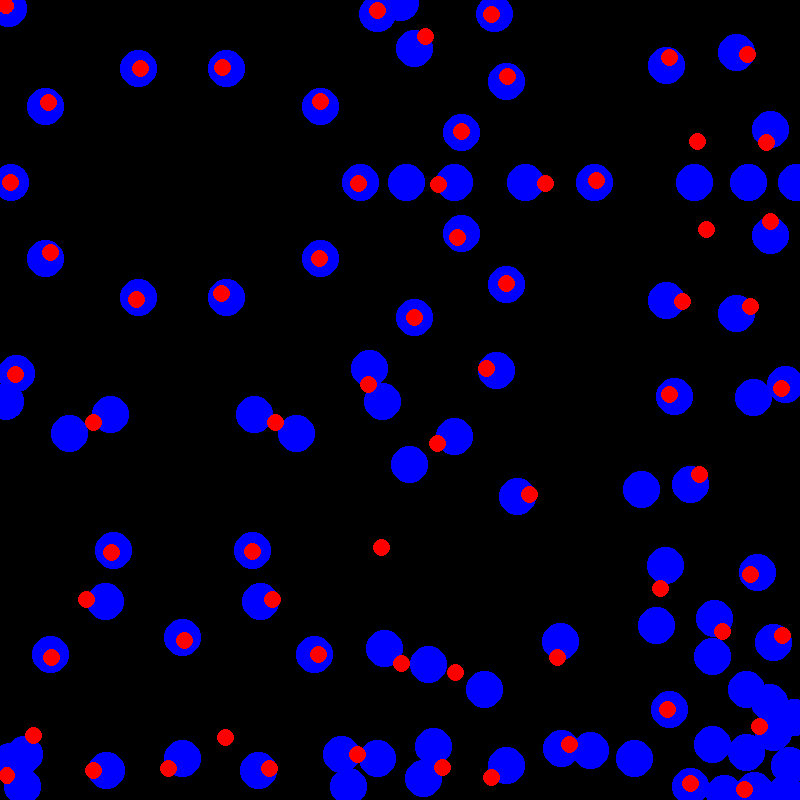

In [45]:
im2